# Simple Storm Surge Inundation Modeling

_**Caitlin Haedrich and Pratikshya Regmi**, North Carolina State University_


In this example we will use some of GRASS GIS hydrology tools, namely:

* [r.lake](https://grass.osgeo.org/grass-stable/manuals/r.lake.html): to fill a lake to a target water level from a given start point or seed raster
* [r.lake.series](https://grass.osgeo.org/grass-stable/manuals/r.lake.series.html): addon which runs r.lake for different water levels


In [1]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("nags_head/PERMANENT");
# gj.init("nags_head/flooding");

In [2]:
# Make a new mapset for this part
gs.run_command("g.mapset", mapset="flooding", location="nags_head", flags="c")

In [58]:
!g.region region=jockeys_ridge w=w+1200 -p

projection: 99 (NAD83(HARN) / North Carolina)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      250984
south:      249364
west:       913340
east:       914462
nsres:      1
ewres:      1
rows:       1620
cols:       1122
cells:      1817640


In [ ]:
!g.extension extension=r.lake.series

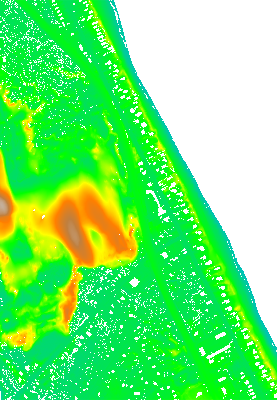

In [59]:
flood1 = gj.Map(use_region=True)
flood1.d_rast(map="JR_2014")
flood1.show()

In [60]:
!r.neighbors input=JR_2014 output=JR_2014_filled method=average size=9

!r.mapcalc "JR_2014_filled_bath = if(isnull(JR_2014_filled), -5.0, JR_2014_filled)"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Color table for raster map <JR_2014_filled_bath> set to 'elevation'


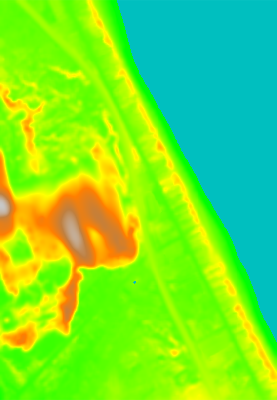

In [61]:
!r.colors map=JR_2014_filled_bath color=elevation

flood1 = gj.Map()
flood1.d_rast(map="JR_2014_filled_bath")
flood1.show()

In [62]:
fill_point = "914151,250381"

gs.write_command("v.in.ascii", input="-", output="fill_point", separator="comma", stdin=fill_point)

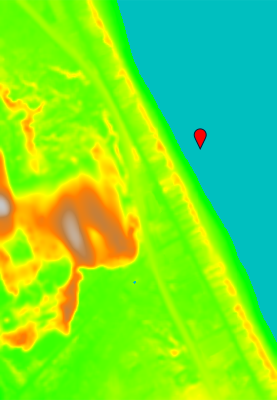

In [63]:
flood1 = gj.Map()
flood1.d_rast(map="JR_2014_filled_bath")
flood1.d_vect(map="fill_point", icon="basic/pin", size=20, fill_color="red")
flood1.show()

In [64]:
gs.run_command("r.lake.series",
                elevation="JR_2014_filled_bath",
                output="flooding",
                start_water_level=3.0,
                end_water_level=4.0,
                water_level_step=0.25,
                coordinates=fill_point
              )

In [65]:
from io import StringIO
import pandas as pd

pd.read_csv(StringIO(gs.read_command("t.rast.list", input="flooding", separator="comma")))

,name,mapset,start_time,end_time
0,flooding_3.0,flooding,1,NaN
1,flooding_3.25,flooding,31,NaN
2,flooding_3.5,flooding,61,NaN
3,flooding_3.75,flooding,91,NaN
4,flooding_4.0,flooding,121,NaN


r.lake.series creates a space-time dataset. We can use the [temporal modules](https://grass.osgeo.org/grass-stable/manuals/temporal.html) to further work with the data.

Let's visualize the results:

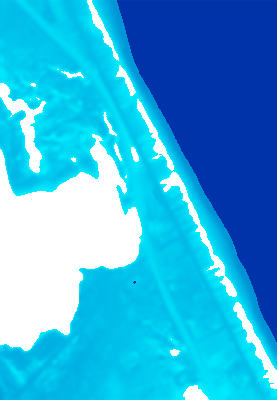

In [66]:
flood1 = gj.Map()
flood1.d_rast(map="flooding_4.0")
flood1.show()

In [67]:
!r.relief input=JR_2014_filled_bath output=JR_2014_shade

   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Shaded relief raster map <JR_2014_shade> complete


In [68]:
gs.run_command("t.rast.colors", input="flooding", color="water")

timemap = gj.TimeSeriesMap()
timemap.d_rast(map="JR_2014_shade")
timemap.add_raster_series("flooding")
timemap.d_legend(at=(1, 40, 90, 95))
#timemap.show() 

In [69]:
timemap.save(filename="flood.gif");

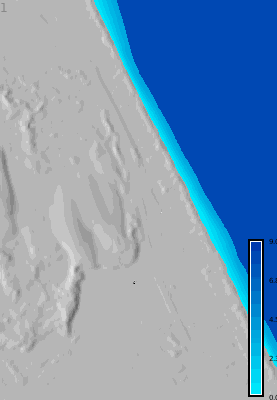

In [70]:
from IPython.display import display, Image

display(Image(filename="flood.gif"))